In [24]:
# Standard modules
import pickle as pkl
import numpy as np
import heapq as hq
from icecream import ic
# PyTorch
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from torch_geometric.utils import to_networkx
# NetworkX
import networkx as nx
# RDKit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
# Bokeh
from bokeh.io import output_notebook, show, export_svg
output_notebook()
# Science python
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
# Modules from local files
from GNN_mol import GNN
from Dataset import XASDataset
from train import train_model
from test import test_model
from utils import plot_learning_curve, bokeh_spectra, calculate_rse, plot_spectra

Loading BokehJS ...

#### Define functions to be used

In [2]:
def pred_spec(model, index, test_dataset):
    # Set the model to evaluation mode
    model.eval()

    # Get a single graph from the test dataset
    graph_index = index # Index of the graph you want to predict on
    graph_data = test_dataset[graph_index].to(device)
    batch = Batch.from_data_list([graph_data])

    # Pass the graph through the model
    with torch.no_grad():
        pred = model(batch)

    # Access the predicted output for the single graph
    pred_graph = pred[0]
    true_spectrum = graph_data.y.cpu().numpy()
    predicted_spectrum = pred.cpu().numpy()
    predicted_spectrum = predicted_spectrum.reshape(-1)
    
    return predicted_spectrum, true_spectrum

#### Import dataset

In [3]:
# Path raw directory containing the data
path = "./"
# Load and create the dataset
dataset = XASDataset(path)

In [4]:
# Show detail of the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print('')

# Show details of the first molecule/graph in dataset
data = dataset[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

XASDataset(319)
------------
Number of graphs: 319
Number of features: 10
Number of classes: 63482

Data(x=[30, 10], edge_index=[2, 76], y=[200], edge_attrs=[76, 4], smiles='[c:0]12[c:4]3[c:8]4[c:10]5[cH:11][cH:14][c:15]6[c:13]4[c:17]4[c:19]([cH:18][cH:16]6)[cH:20][c:22]([OH:25])[c:23]([c:21]14)[CH2:24][CH:1]1[C:2]2([CH:3]=[CH:5][C:6]32[CH:7]([CH:9]5[C:12](=[O:26])[OH:27])[O:29]2)[O:28]1')
------------
Number of nodes: 30
Number of edges: 76
Average node degree: 2.53
Has isolated nodes: False
Has self loops: False
Is undirected: True


#### View data

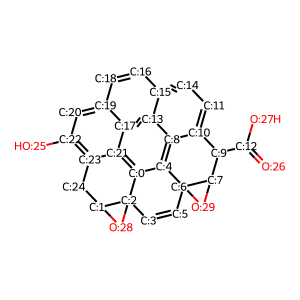

In [5]:
mol = Chem.MolFromSmiles(data.smiles)
mol

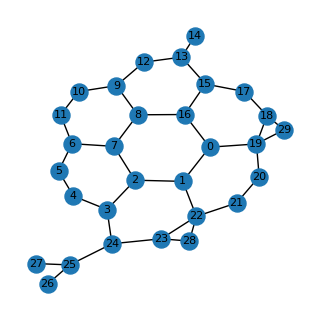

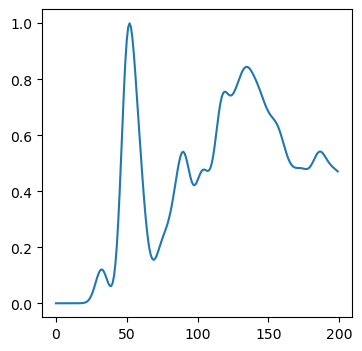

In [6]:
# Show graph representation of molecule
mol_graph = to_networkx(data, to_undirected=True)

plt.figure(figsize=(3,3))

nx.draw(mol_graph, with_labels=True, node_size=150, font_size=8)

plt.show()

# Show molecule spectrum
plt.figure(figsize=(4,4))

plt.plot(data.y)

plt.show()

#### Split up dataset

In [7]:
# Split data into test, validation and test
train_dataset = dataset[0:252]
val_dataset = dataset[252:280]
test_dataset = dataset[280:]

# Pass into dataloader
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)

print(f'Length of training data loader: {len(train_loader.dataset)}')
print(f'Length of validation data loader: {len(val_loader.dataset)}')
print(f'Length of testing data loader: {len(test_loader.dataset)}')

Length of training data loader: 252
Length of validation data loader: 28
Length of testing data loader: 39


#### Set neural network properties

In [8]:
num_tasks = 200
num_layers = 3
emb_dim = dataset.num_features
in_channels = [int(emb_dim), 100, 200]
out_channels = [100, 200, 200]
gnn_type = "gcn"
heads = int(1)
drop_ratio = 0.8
graph_pooling = "mean"

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
model = model.to(device)
print(model)

GNN(
  (gnn_node): GNN_node(
    (convs): ModuleList(
      (0): GCNConv(10, 100)
      (1): GCNConv(100, 200)
      (2): GCNConv(200, 200)
    )
    (batch_norms): ModuleList(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1-2): 2 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=200, out_features=200, bias=True)
)


In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

#### Run neural network training

In [13]:
num_epochs = 300
best_val_error = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    loss = train_model(epoch, train_loader, model, device, optimizer)

    val_error = test_model(val_loader, model, device)

    scheduler.step(val_error)

    train_losses.append(loss)

    val_losses.append(val_error)

    current_lr = optimizer.param_groups[0]["lr"]

    if best_val_error is None or val_error <= best_val_error:

        best_val_error = val_error

    if epoch % 25 == 0:
        print(f"Epoch: {epoch:03d}, LR: {current_lr:7f}, TrainLoss: {loss:.7f}, ValLoss:{val_error:7f}, Best_ValLoss:{best_val_error:7f}")

Epoch: 000, LR: 0.010000, TrainLoss: 0.2147216, ValLoss:0.075423, Best_ValLoss:0.075423
Epoch: 025, LR: 0.010000, TrainLoss: 0.0127087, ValLoss:0.011590, Best_ValLoss:0.009718
Epoch: 050, LR: 0.010000, TrainLoss: 0.0105826, ValLoss:0.010176, Best_ValLoss:0.009264
Epoch: 075, LR: 0.010000, TrainLoss: 0.0096960, ValLoss:0.009969, Best_ValLoss:0.009204
Epoch: 100, LR: 0.010000, TrainLoss: 0.0091788, ValLoss:0.009837, Best_ValLoss:0.009204
Epoch: 125, LR: 0.010000, TrainLoss: 0.0087774, ValLoss:0.009886, Best_ValLoss:0.009204
Epoch: 150, LR: 0.010000, TrainLoss: 0.0089890, ValLoss:0.009259, Best_ValLoss:0.009153
Epoch: 175, LR: 0.010000, TrainLoss: 0.0089163, ValLoss:0.009500, Best_ValLoss:0.009064
Epoch: 200, LR: 0.010000, TrainLoss: 0.0085838, ValLoss:0.009684, Best_ValLoss:0.009064
Epoch: 225, LR: 0.010000, TrainLoss: 0.0086400, ValLoss:0.009648, Best_ValLoss:0.009064
Epoch: 250, LR: 0.010000, TrainLoss: 0.0087488, ValLoss:0.009451, Best_ValLoss:0.009064
Epoch: 275, LR: 0.005000, TrainL

In [14]:
model_name = 'model_gnn_test.pt'
torch.save(model.state_dict(), "ML_models/" + model_name)

#### View loss

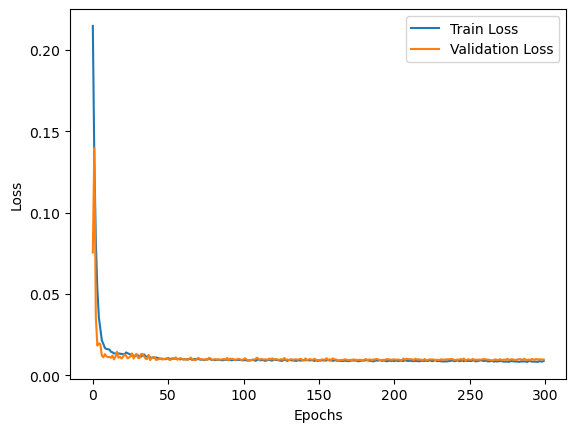

In [15]:
plot_learning_curve(num_epochs, train_losses, val_losses)

#### Load model and predict spectra

In [16]:
# Load the saved model
num_tasks = 200

model = GNN(
    num_tasks,
    num_layers,
    emb_dim,
    in_channels,
    out_channels,
    gnn_type,
    heads,
    drop_ratio,
    graph_pooling,
)
mode = model.to(device)
model.load_state_dict(torch.load("ML_models/" + model_name))

<All keys matched successfully>

#### Extract predicted and true spectra

In [17]:
# Create empty dictionary to contain spectra
predict = {}
true = {}

# Loop over all molecules in test dateset and assign to dictionary index
for index in range(len(test_dataset)):
    predict[index], true[index] = pred_spec(model, index, test_dataset)

# Parse spectra into dictionary
model_dict = [predict, true]

name = 'spectra_ml_test.pkl'

with open("spectra_results/" + name, "wb") as file:
    pkl.dump(model_dict, file)

#### View and analysis predictions

In [18]:
file = open('spectra_results/' + name, 'rb')
data = pkl.load(file)

predict = data[0]
true = data[1]

In [19]:
wasser = []
mse = []
rse = []

for x in range(len(predict)):
    # Wasserstein metric
    wass_temp = wasserstein_distance(predict[x], true[x])
    wasser.append(wass_temp)
    # Mean squared error
    mse_temp = mean_squared_error(predict[x], true[x])
    mse.append(mse_temp)
    # RSE
    rse_temp = calculate_rse(predict[x], true[x])
    rse.append(rse_temp)

print(f"Average Wasserstein distance = {sum(wasser) / len(wasser)}")
print(f"Average MSE = {sum(mse) / len(mse)}")
print(f'Average RSE = {sum(rse) / len(rse)}')

Average Wasserstein distance = 0.04550661022650138
Average MSE = 0.007301506540816476
Average RSE = 0.04019215957476234


In [20]:
five_best = hq.nsmallest(5, rse)
five_worst = hq.nlargest(5, rse)

best = []
worst = []

for x in range(5):
    best_idx = rse.index(five_best[x])
    best.append(best_idx)

    worst_idx = rse.index(five_worst[x])
    worst.append(worst_idx)

print('The 5 best RSE values are:')
for x in range(5):
    print(f'RSE = {five_best[x]:.3f}, graph number = {best[x]}')

print('')
print('The 5 worst RSE values are:')
for x in range(5):
    print(f'RSE = {five_worst[x]:.3f}, graph number = {worst[x]}')

The 5 best RSE values are:
RSE = 0.018, graph number = 33
RSE = 0.025, graph number = 12
RSE = 0.028, graph number = 14
RSE = 0.028, graph number = 16
RSE = 0.029, graph number = 11

The 5 worst RSE values are:
RSE = 0.073, graph number = 36
RSE = 0.061, graph number = 19
RSE = 0.060, graph number = 26
RSE = 0.056, graph number = 4
RSE = 0.052, graph number = 23


In [23]:
# Plot best spectra prediction
p = bokeh_spectra(predict[best[0]], true[best[0]])
show(p)

In [22]:
# Plot worst spectra prediction
p = bokeh_spectra(predict[worst[0]], true[worst[0]])
show(p)